<a href="https://colab.research.google.com/github/ravijp/JBMClassification/blob/master/Playing%20with%20models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get files from Github

In [1]:
!git clone https://github.com/ravijp/JBMClassification.git

Cloning into 'JBMClassification'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (254/254), done.
remote: Total 254 (delta 0), reused 254 (delta 0), pack-reused 0
Receiving objects: 100% (254/254), 770.72 MiB | 41.39 MiB/s, done.
Checking out files: 100% (250/250), done.


### Import necessary modules 

In [1]:
import glob
from random import shuffle
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import optimizers
%matplotlib inline

W0417 15:52:03.278015 140488601999232 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


# Data Preparation

In [0]:
def getLabel(filePaths):
	labels = []
	for img in filePaths:
		if 'Healthy' in img:
			labels.append(0)
		elif 'defects' in img:
			labels.append(1)

	dataZip = list(zip(filePaths, labels))
	shuffle(dataZip)
	filePaths, labels = zip(*dataZip)
	return filePaths, labels


def split_trainTest(imgsAll, labelAll, splitRatio = 0.20):
	dataZip = list(zip(imgsAll, labelAll))
	shuffle(dataZip)
	imgsAll, labelAll = zip(*dataZip)
	splitPoint = int(len(imgsAll)*splitRatio)

	trainImgs = imgsAll[:int(len(imgsAll) - splitPoint)]
	trainLabel = labelAll[:int(len(imgsAll) - splitPoint)]
	testImgs = imgsAll[int(len(imgsAll)-splitPoint):]
	testLabel = labelAll[int(len(imgsAll)-splitPoint):]

	return trainImgs, testImgs, trainLabel, testLabel

images, labels = getLabel(glob.glob('/content/JBMClassification/*/*.jpg'))
# split the images into train and test sets.
X_train, X_test, y_train, y_test = split_trainTest(images, labels,  splitRatio=0.25)

In [3]:
display(print(f'SHape of training dataset {len(X_train)} and shape of validation set is {len(X_test)}'))

IMAGE_SIZE = (224, 224)

train_imgs = [img_to_array(load_img(img, target_size=IMAGE_SIZE)) for img in X_train]
train_imgs = np.array(train_imgs)
train_labels = list(y_train)
validation_imgs = [img_to_array(load_img(img, target_size=IMAGE_SIZE)) for img in X_test]
validation_imgs = np.array(validation_imgs)
validation_labels = list(y_test)

SHape of training dataset 188 and shape of validation set is 62


None

In [4]:
# Scale the images as Deep learning models tend to work good with smaller input

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

Train dataset shape: (188, 224, 224, 3) 	Validation dataset shape: (62, 224, 224, 3)


### Intialization





In [0]:
batch_size = 32
num_classes = 2
epochs = 30
input_shape = (224, 224, 3)
img_width, img_height = 224, 224

### Image Augmentation

In [0]:
# train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
#                                    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
#                                    horizontal_flip=True, fill_mode='nearest')

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs_scaled, train_labels, batch_size=batch_size)
val_generator = val_datagen.flow(validation_imgs_scaled, validation_labels, batch_size=batch_size//2)

# Model importing and setting layers to non trainable

In [7]:
from keras.models import Model
import keras
from keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(224, 224, 3))

output = inception.layers[-1].output
output = keras.layers.Flatten()(output)
incept_model = Model(inception.input, output)

incept_model.trainable = False
for layer in incept_model.layers:
    layer.trainable = False
    
# import pandas as pd
# pd.set_option('max_colwidth', -1)
# layers = [(layer, layer.name, layer.trainable) for layer in incept_model.layers]
# display(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.
W0417 15:52:59.563727 140488601999232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


87916544/87910968 [==============================] - 2s 0us/step


Getting bottle neck features 

In [9]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(incept_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(incept_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (188, 51200) 	Validation Bottleneck Features: (62, 51200)


### Model 

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = incept_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(64, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0417 15:54:41.192270 140488601999232 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                3276864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total para

## Run our model

In [15]:
history = model.fit(x=train_features_vgg, y=train_labels,
                    validation_data=(validation_features_vgg, validation_labels),
                    batch_size=batch_size,
                    epochs=150,
                    verbose=1)

Train on 188 samples, validate on 62 samples
Epoch 1/150
188/188 [==============================] - 0s 2ms/step - loss: 0.1236 - acc: 0.9574 - val_loss: 0.3230 - val_acc: 0.8387
Epoch 2/150
188/188 [==============================] - 0s 2ms/step - loss: 0.0968 - acc: 0.9734 - val_loss: 0.3270 - val_acc: 0.8226
Epoch 3/150
188/188 [==============================] - 0s 2ms/step - loss: 0.1246 - acc: 0.9628 - val_loss: 0.3158 - val_acc: 0.8387
Epoch 4/150
188/188 [==============================] - 0s 2ms/step - loss: 0.1173 - acc: 0.9574 - val_loss: 0.3088 - val_acc: 0.8387
Epoch 5/150
188/188 [==============================] - 0s 2ms/step - loss: 0.1374 - acc: 0.9574 - val_loss: 0.3160 - val_acc: 0.8065
Epoch 6/150
188/188 [==============================] - 0s 2ms/step - loss: 0.1232 - acc: 0.9628 - val_loss: 0.3158 - val_acc: 0.8387
Epoch 7/150
188/188 [==============================] - 0s 2ms/step - loss: 0.0780 - acc: 0.9840 - val_loss: 0.3177 - val_acc: 0.8065
Epoch 8/150
188/188 [===

# Plot validation and training accuracy

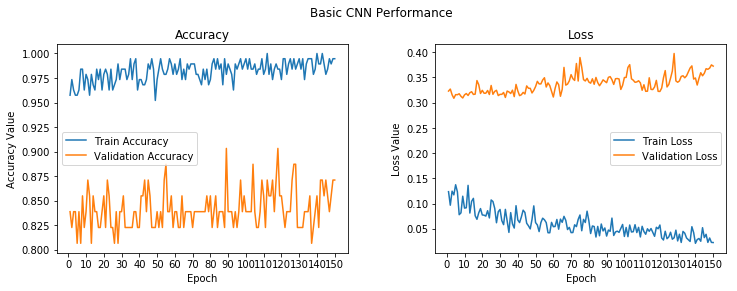

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,151))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 151, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 151, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('model_v7.h5')
f.savefig('model_v7.png')



```
# from IPython.display import Image
# %matplotlib inline
from PIL import Image
display(Image.open('model_v6.png'))

```

# Version numbering



1.   Version number = 1
>  Batch size = 32. 


>  Layer structure  = 
```
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
```




---



2.   Version number = 2
>  Batch size = 32

>  Layer structure  = 
```
model.add(Dense(128, activation='relu', input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
```


---


3.   Version number = 3
>  Batch size = 32

>  Layer structure  = 
```
model.add(Dense(524, activation='relu', input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
```


---



4.   Version number = 4
>  Batch size = 32

>  Layer structure  = 
```
model.add(Dense(256, activation='relu', input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
```


---


5.   Version number = 5
>  Batch size = 32

>  Layer structure  = 
```
model.add(Dense(256, activation='relu', input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
```

---

6.   Version number = 6
>  Batch size = 32

>  Layer structure  = 
```
model.add(Dense(256, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
```



---



7.   Version number = 7
>  Batch size = 32

>  Layer structure  = 
```
model.add(Dense(64, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
```


---



8.   Version number = 8
>  Batch size = 32

>  Layer structure  = 

```
model.add(Dense(1024, activation='relu', input_dim=input_shape))
model.add(Dropout(0.6))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
```

---


9.   Version number = 9
>  Batch size = 32

>  Layer structure  = 

```
model.add(Dense(1024, activation='relu', input_dim=input_shape))
model.add(Dropout(0.6))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))



model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4, decay=1e-5),
              metrics=['accuracy'])

```


10. V11

```
model.add(Dense(64, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
```


11. V-12

```
model.add(Dense(64, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
```

12. v-13

```
model.add(Dense(64, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
```


13. v-14

```
model.add(Dense(64, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
```

14. v-15

```
model.add(Dense(1024, activation='relu', input_dim=input_shape))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
```